<a href="https://colab.research.google.com/github/shaohs/ACE592-2019F/blob/master/Colab_Weather/HH_Fit_Step5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load necessary module

In [0]:
!pip install sklearn
# !pip install pyreadr

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import re
import numpy as np
import pandas as pd
import datetime as dtime
import matplotlib.pyplot as plt
import shutil
import zipfile
# import pyreadr

try:
    from google.colab import files
    %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow import feature_column, keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [0]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%rm -r /tmp/output/
%mkdir /tmp/output/
%mkdir /tmp/output/fig/
%mkdir /tmp/output/weight/

In [0]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 200

## From the URL download the dataframe.

In [0]:
load_raw = False #@param {type:"boolean"}

if load_raw:

    !wget --no-check-certificate \
        "https://storage.googleapis.com/hansen-public/weatherization/target.zip" \
        -O /tmp/target.zip
        
    with zipfile.ZipFile('/tmp/target.zip', 'r') as zip_ref:
        zip_ref.extractall('/tmp')

    dataframe = pd.read_csv('/tmp/targetV3.csv')
    dataframe_eng = pd.read_csv('/tmp/IHWAP_CE.csv')
    dataframe_temp = pd.read_csv('/tmp/targetV2.csv')


    merge_on = ['Household']
    dataframe_temp.drop(['stories', 'occupants'], axis=1, inplace=True)
    new_data_keep = list(set([col for col in dataframe_temp]).difference([col for col in dataframe])) + merge_on
    dataframe_temp = dataframe_temp[new_data_keep]

    unique_ind = dataframe_temp.groupby('Household', as_index=False).agg(lambda s:np.unique(s).size==1).all()
    dataframe_temp = dataframe_temp.iloc[:, unique_ind.values].drop_duplicates(['Household']).reset_index(drop=True)
    dataframe = dataframe.merge(dataframe_temp, on=merge_on, validate='m:1')

    dataframe['auditmonth'].fillna('2100m1', inplace=True) # Fill no obs by str '0m0'
    dataframe['Date'] = dataframe['auditmonth'].str.split(pat = "m")
    dataframe['audit_year'] = dataframe['Date'].str[0].astype(int)
    dataframe['audit_month'] = dataframe['Date'].str[1].astype(int)
    dataframe = dataframe.drop(['auditmonth', 'Date'], 1)

else:

    !wget --no-check-certificate \
        "https://storage.googleapis.com/hansen-public/weatherization/targetV4.zip" \
        -O /tmp/target.zip
        
    with zipfile.ZipFile('/tmp/target.zip', 'r') as zip_ref:
        zip_ref.extractall('/tmp')

    dataframe = pd.read_csv('/tmp/targetV4.csv')
    dataframe_eng = pd.read_csv('/tmp/IHWAP_CE.csv')

    dataframe['hasAC'] = (dataframe['Real_tot_actAirCon'] > 0).astype(int)

    dataframe['auditmonth'].fillna(0, inplace=True) # Fill no obs by str '0m0'
    dataframe['audit_year'] = (dataframe['auditmonth']//12 + 1960).astype(int)
    dataframe['audit_month'] = (dataframe['auditmonth']%12+1).astype(int)
    dataframe = dataframe.drop(['auditmonth'], 1)


--2020-04-15 01:04:13--  https://storage.googleapis.com/hansen-public/weatherization/targetV4.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 2607:f8b0:4001:c14::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37371747 (36M) [application/zip]
Saving to: ‘/tmp/target.zip’

/tmp/target.zip     100%[===================>]  35.64M   175MB/s    in 0.2s    

2020-04-15 01:04:13 (175 MB/s) - ‘/tmp/target.zip’ saved [37371747/37371747]



In [0]:
dataframe = dataframe.drop(['end_day'], 1)

dataframe.sort_values(by=['Household', 'end_year', 'end_month', 'meterdays'], inplace=True)
# keeping the ones with larger number of meterdays
bool_series = dataframe[['Household', 'end_year', 'end_month']].duplicated(keep = 'last') 
dataframe = dataframe[~bool_series].reset_index(drop=True)

try:
    dataframe['MainHeatBTU_wins_zero'] = (dataframe['MainHeatBTU_wins'] == 0).astype(int)
except:
    pass

In [0]:
# dataframe.dtypes
# dataframe.head()
# dataframe.describe()

In [0]:
# unique_list = dataframe.groupby('Household', as_index=False).agg(lambda s:np.unique(s).size==1).all()

Month Average Usage and Std.Dev

In [0]:
month_usage_mean = dataframe[['total_mmbtu', 'end_year', 'end_month']].groupby(['end_year', 'end_month']).mean().reset_index()
month_usage_std = dataframe[['total_mmbtu', 'end_year', 'end_month']].groupby(['end_year', 'end_month']).std().reset_index()

month_usage_mean.rename(columns={'total_mmbtu': 'month_mmbtu_avg'}, inplace=True)
month_usage_std.rename(columns={'total_mmbtu': 'month_mmbtu_std'}, inplace=True)

dataframe = dataframe.merge(month_usage_mean, on=['end_year', 'end_month'], validate='m:1')
dataframe = dataframe.merge(month_usage_std, on=['end_year', 'end_month'], validate='m:1')

Select Data before Upgrade Treatment

In [0]:
has_pretreat = dataframe[['Household', 'treated']].groupby('Household').min().reset_index().rename(columns={'treated': 'has_pretreat'})
has_pretreat['has_pretreat'] = (1-has_pretreat['has_pretreat']).astype(int)
dataframe = dataframe.merge(has_pretreat, on=['Household'], validate='m:1')

In [0]:
pretreat_data = dataframe.loc[dataframe['treated'] == 0].copy()
pretreat_data['pretreat_2_monthavg'] = pretreat_data['total_mmbtu'] - pretreat_data['month_mmbtu_avg']

pretreat_data = pretreat_data[['Household', 'pretreat_2_monthavg', 'total_mmbtu']]

dataframe = dataframe.merge(pretreat_data.groupby(['Household']).mean().reset_index().rename(columns={'pretreat_2_monthavg': 'pretreat_diff_avg', 'total_mmbtu': 'pretreat_avg'}), 
                            how='left', on=['Household'], validate='m:1')
dataframe = dataframe.merge(pretreat_data.groupby(['Household']).std().reset_index().rename(columns={'pretreat_2_monthavg': 'pretreat_diff_std', 'total_mmbtu': 'pretreat_std'}), 
                            how='left', on=['Household'], validate='m:1')

dataframe = dataframe.fillna(value=0)

In [0]:
# dataframe = dataframe.loc[dataframe['treated'] == 1]
# dataframe = dataframe.loc[dataframe['has_pretreat'] == 1]


Keep household level data

In [0]:
data_colnames = [col for col in dataframe]

In [0]:
DropVar = ['Household', 'mmbtu_save', 'pct_save', 'Real_total_cost', 'jobnumber', 'nmonths', 
           'eng_savings_pct', 'realized_savings_pct', 'realized_savings_mmbtu', 
           'baseline_npv', 'disc6_npv', 'disc0_npv', 'year30_npv', 'year10_npv', 
           'ExistingConsumption', 'ProjectedConsumption', 'total_mmbtu', 
           'end_day', 'BlowerReduc', 'Blower_Post']

#  + [col for col in dataframe if col.startswith('Real_tot_')]

Target = ['total_mmbtu']

CategoryVar = ['stories', 'occupants', 'priority', 'ShieldingClass', 'builddate', 
               'end_month', 'end_year', 'MainHeatType', 'audit_year',
               'audit_month', 'noccupants', 'nwindows', 'nstories',
               'builddate', 'CountyID', 'tbesetting', 'HeatTypeMain', 'Disabled',
               'nbedrooms', 'priority', 'ProgramYear', 'MainHeatBTU_wins_zero', 'HeatTypeMain']
BoolVar = ['noattic', 'hasAC', 'liheap', 'WHoperates', 'MainHeatOperates', 'WHoperational',
           'MainHeatOperational', 'hasattic', 'renter', 'female', 'haselderly', 'hasminor', 
           'treated', 'has_pretreat']
DummyVar = ['white', 'black', 'hispanic', 'asian', 'nativeamerican', 'otherrace']


DropVar = list(set(DropVar).intersection(data_colnames))
Target = list(set(Target).intersection(data_colnames))
DropVar = list(set(DropVar).difference(Target))
CategoryVar = list(set(CategoryVar).intersection(data_colnames))
BoolVar = list(set(BoolVar).intersection(data_colnames))
DummyVar = list(set(DummyVar).intersection(data_colnames))

NotNumberVar = CategoryVar + BoolVar + DummyVar

# dataframe = dataframe.drop(DropVar, 1)

NotScale = NotNumberVar + Target + DropVar

dataframe['nstories'] = (10 * dataframe['nstories']).astype(int)

dataframe_copy = dataframe.copy()

# dataframe.head()

In [0]:
# dataframe[list(set(data_colnames).difference(DropVar).difference(NotNumberVar))].isna().any()

## Normalize the variables

In [0]:
scaler = preprocessing.StandardScaler()

scaler.fit(dataframe.drop(NotScale, axis=1))
ScalePara = dataframe.drop(NotScale, axis=1).iloc[0:0].copy()

ScalePara.loc[len(ScalePara)] = scaler.mean_
ScalePara.loc[len(ScalePara)] = scaler.scale_
ScalePara.index = ['Mean','STD']

for column in dataframe:
    if column not in NotScale:
        dataframe[column] = preprocessing.scale(dataframe[column])

# dataframe.head()

## Split the dataframe into train, validation, and test

In [0]:
random_num = np.random.randint(2**32 - 1)
print(random_num)

3635306818


In [0]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.1, n_splits=2, random_state=random_num).split(dataframe, groups=dataframe['Household']))

train = dataframe.iloc[train_inds].copy()
test = dataframe.iloc[test_inds].copy()

train_inds, val_inds = next(GroupShuffleSplit(test_size=.1, n_splits=2).split(train, groups=train['Household']))

val = train.iloc[val_inds].copy()
train = train.iloc[train_inds].copy()

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

train = train.drop(DropVar, 1)
val = val.drop(DropVar, 1)
test = test.drop(DropVar, 1)
dataframe = dataframe.drop(DropVar, 1)

449307 train examples
50053 validation examples
56583 test examples


## Create an input pipeline using tf.data

In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe

def df_to_dataset(dataframe, shuffle=True, batch_size=64, target=Target[0]):
    dataframe = dataframe.copy()
    target_saves = dataframe.pop(target)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), target_saves))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Understand the input pipeline

In [0]:
# a small batch size to keep the output readable
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    # print('A batch of sq feet:', feature_batch['sqfeet'])
    # print('A batch of targets:', label_batch)

Every feature: ['end_month', 'end_year', 'treated', 'HDD60', 'HDD65', 'CDD75', 'sqfeet', 'noccupants', 'nwindows', 'nstories', 'builddate', 'CountyID', 'ShieldingClass', 'Blower_Pre', 'tbesetting', 'HeatTypeMain', 'Real_income', 'white', 'black', 'hispanic', 'asian', 'nativeamerican', 'otherrace', 'renter', 'female', 'Disabled', 'haselderly', 'hasminor', 'nbedrooms', 'meterdays', 'priority', 'ProgramYear', 'tmin', 'tmax', 'precip', 'MainHeatBTU_wins', 'hasattic', 'Real_tot_actWallIns', 'Real_tot_actWtHtr', 'WHoperational', 'Real_tot_actHealSfty', 'Attic_RValue', 'Real_tot_actBaseload', 'Real_tot_actAirCon', 'Real_tot_actAirSeal', 'liheapemergency', 'Age', 'Real_tot_actWindow', 'MainHeatBTU', 'MainHeatOperational', 'MainHeatAge', 'Real_tot_actFurnace', 'Real_tot_actFoundation', 'Real_tot_actDoor', 'Real_tot_actAttic', 'Real_tot_actGeneral', 'hasAC', 'audit_year', 'audit_month', 'MainHeatBTU_wins_zero', 'month_mmbtu_avg', 'month_mmbtu_std', 'has_pretreat', 'pretreat_diff_avg', 'pretreat_

## Choose column variable type to use

In [0]:
feature_columns = []

# numeric cols
for header in [item for item in list(feature_batch.keys()) if item not in (NotNumberVar + DropVar)]:
    feature_columns.append(feature_column.numeric_column(header))

# categorical cols
for header in CategoryVar:
    header_cat = feature_column.categorical_column_with_vocabulary_list(
            header, list(dataframe[header].unique()))
    feature_columns.append(feature_column.indicator_column(header_cat))

# Bool cols
for header in BoolVar + DummyVar:
    feature_columns.append(feature_column.bucketized_column(
            feature_column.numeric_column(header), boundaries=[1]))


# Bucked Temp
end_month = feature_column.numeric_column('end_month')
winter_buckets = feature_column.bucketized_column(end_month, boundaries=[3,11])
feature_columns.append(winter_buckets)

tmax = feature_column.numeric_column('tmax')
tmax_bound = np.linspace(dataframe['tmax'].min(), dataframe['tmax'].max(), num=5)
tmax_buckets = feature_column.bucketized_column(tmax, boundaries=tmax_bound.tolist())
feature_columns.append(tmax_buckets)

tmin = feature_column.numeric_column('tmin')
tmin_bound = np.linspace(dataframe['tmin'].min(), dataframe['tmin'].max(), num=5)
tmin_buckets = feature_column.bucketized_column(tmin, boundaries=tmin_bound.tolist())
feature_columns.append(tmin_buckets)

# feature_columns


## Create a feature layer

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Create a new input pipeline with a larger batch size.

In [0]:
batch_size = 128
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)
all_ds = df_to_dataset(dataframe, shuffle=False, batch_size=batch_size)

## Create, compile, and train the model

In [0]:
tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)

lrelu = lambda x: tf.keras.layers.LeakyReLU(alpha=0.3)(x)

model = tf.keras.models.Sequential([
    feature_layer, 
    tf.keras.layers.Dense(128, activation=lrelu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=lrelu, kernel_regularizer=regularizers.l1(0.2)),
    tf.keras.layers.Dense(32, activation=lrelu, kernel_regularizer=regularizers.l1(0.2)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.1)),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1(0.1)),
    tf.keras.layers.Dense(1),
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.0001 * 2**(0 / 35))
early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=10)
optimizer = tf.keras.optimizers.RMSprop(0.0001)

model.compile(loss='mse',
        optimizer=optimizer,
        metrics=['mse'])



In [0]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[lr_schedule, early_stop], verbose=0)
# history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[lr_schedule])

print('\n')

model.summary()

# model.fit(train_ds, epochs=5, validation_data=val_ds)




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  41088     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
dense_2 (Dense)              multiple                  4128      
_________________________________________________________________
dense_3 (Dense)              multiple                  528       
_________________________________________________________________
dense_4 (Dense)              multiple                 

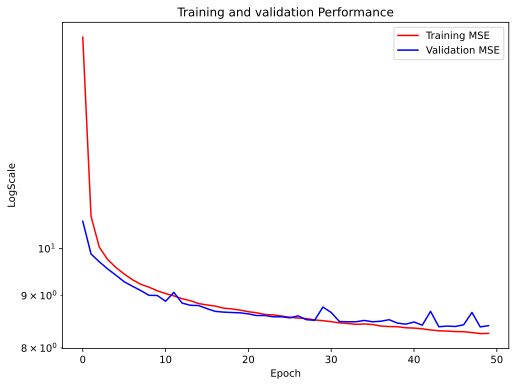

In [0]:
mse = history.history[model.metrics_names[1]]
val_mse = history.history['val_'+model.metrics_names[1]]

epochs = range(len(mse))

plt.figure(num=None, figsize=(8, 6), dpi=200)

plt.plot(epochs, mse, 'r', label='Training '+model.metrics_names[1].upper())
plt.plot(epochs, val_mse, 'b', label='Validation '+model.metrics_names[1].upper())
plt.title('Training and validation Performance')
plt.xlabel('Epoch')
plt.yscale('log') 
plt.ylabel('LogScale')
plt.legend(loc=0)


plt.savefig('/tmp/output/fig/LearningCurve.png', format='png')
plt.show()

## Save Weights (Need Change Here !!) and Load Saved Model

In [0]:
model_version = '1'
# OldWeightID = ''
UseOldWeight = False

!wget --no-check-certificate \
    "https://drive.google.com/uc?export=download&id=11-4gmYIpjR3RUxOX4o5sL03b88rLx2WJ" \
    -O /tmp/592Model_Old_Weight.h5

--2020-04-15 03:55:50--  https://drive.google.com/uc?export=download&id=11-4gmYIpjR3RUxOX4o5sL03b88rLx2WJ
Resolving drive.google.com (drive.google.com)... 108.177.111.138, 108.177.111.139, 108.177.111.100, ...
Connecting to drive.google.com (drive.google.com)|108.177.111.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v34vjpihmngc9i9q3ab5h8sv7s4bhdd4/1586922900000/10552551231187590271/*/11-4gmYIpjR3RUxOX4o5sL03b88rLx2WJ?e=download [following]
--2020-04-15 03:55:50--  https://doc-0k-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v34vjpihmngc9i9q3ab5h8sv7s4bhdd4/1586922900000/10552551231187590271/*/11-4gmYIpjR3RUxOX4o5sL03b88rLx2WJ?e=download
Resolving doc-0k-1c-docs.googleusercontent.com (doc-0k-1c-docs.googleusercontent.com)... 173.194.192.132, 2607:f8b0:4001:c0e::84
Connecting to doc-0k-1c-docs.googleusercontent.com (d

In [0]:
model.save_weights('/tmp/output/weight/592ModelStep3_V'+model_version+'_Weight.h5')

In [0]:
if UseOldWeight:
    model.load_weights('/tmp/592Model_Old_Weight.h5')
    # model.fit(train_ds, epochs=1, validation_data=val_ds, callbacks=[lr_schedule, early_stop])

## Test the model

In [0]:
loss, metrics_value_test = model.evaluate(test_ds)
print(model.metrics_names[1].upper()+ ':', metrics_value_test)
print('Root-' + model.metrics_names[1].upper() + ':', np.sqrt(metrics_value_test))

443/443 [==============================] - 3s 6ms/step - loss: 10.0666 - mse: 8.3872
MSE: 8.387151718139648
Root-MSE: 2.8960579618059525


In [0]:
loss, metrics_value_all = model.evaluate(all_ds)
print(model.metrics_names[1].upper() + ' on all data:', metrics_value_all)

4344/4344 [==============================] - 29s 7ms/step - loss: 9.6571 - mse: 7.9778
MSE on all data: 7.977787494659424


## Save prediction

In [0]:
pred_saves = model.predict(all_ds)

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(dataframe[Target[0]], pred_saves)

7.977786554249345

In [0]:
test_pred_saves = model.predict(test_ds)
test[Target[0]+'_pred'] = test_pred_saves


dataframe['end_date'] = dataframe.end_year * 10000 + dataframe.end_month * 100 + 1
dataframe['end_date'] = pd.to_datetime(dataframe['end_date'].astype('str'), errors='coerce', format='%Y%m%d').dt.strftime('%Y-%m')
dataframe['audit_date'] = dataframe.audit_year * 10000 + dataframe.audit_month * 100 + 1
dataframe['audit_date'] = pd.to_datetime(dataframe['audit_date'].astype('str'), errors='coerce', format='%Y%m%d').dt.strftime('%Y-%m')
dataframe[Target[0]+'_pred'] = pred_saves

dataframe_copy['end_date'] = dataframe_copy.end_year * 10000 + dataframe_copy.end_month * 100 + 1
dataframe_copy['end_date'] = pd.to_datetime(dataframe_copy['end_date'].astype('str'), errors='coerce', format='%Y%m%d').dt.strftime('%Y-%m')
dataframe_copy['audit_date'] = dataframe_copy.audit_year * 10000 + dataframe_copy.audit_month * 100 + 1
dataframe_copy['audit_date'] = pd.to_datetime(dataframe_copy['audit_date'].astype('str'), errors='coerce', format='%Y%m%d').dt.strftime('%Y-%m')
dataframe_copy[Target[0]+'_pred'] = pred_saves

# dataframe_copy.head()

In [0]:
# dataframe_copy.to_csv('/tmp/output/592Model_Results.csv', index=False)

# ScalePara.to_csv('/tmp/output/592Model_Scale.csv', index=True)

## Some Aux Functions

In [0]:
def rmse_group(g):
    try:
        rmse_cal = np.sqrt(mean_squared_error(g[Target[0]], g[Target[0]+'_pred']))
    except:
        rmse_cal = np.nan
    return pd.Series(dict(rmse = rmse_cal))

def error_perc_group(g):
    perc_cal = np.median(np.absolute(100 * (g[Target[0]+'_pred'] - g[Target[0]])/g[Target[0]]))
    return pd.Series(dict(perc_error = perc_cal))


In [0]:
def error_bin(g, treat, pretreat, suffix, title_prefix, formats='png'):


    if g == 'All':
        df_in = dataframe[[Target[0], Target[0]+'_pred', 'treated', 'has_pretreat']].copy()
    elif g == 'Test':
        df_in = test[[Target[0], Target[0]+'_pred', 'treated', 'has_pretreat']].copy()
    
    if pretreat == 1: treat = 1

    df_in = df_in.loc[df_in['treated'] == treat]
    df_in = df_in.loc[df_in['has_pretreat'] == pretreat]

    Bins = np.linspace((df_in[[Target[0], Target[0]+'_pred']].values.min()), 
                        (df_in[[Target[0], Target[0]+'_pred']].values.max()), 
                        num=32, dtype = int)
                
    Bins = Bins[1:-1]
    Title = title_prefix + ' Groups by Actual Data ('+ g +' Data)'
    SaveName = '/tmp/output/fig/ErrorByBinsTest_' + suffix + '.' + formats

    fig, ax = plt.subplots()


    df_in.groupby(pd.cut(df_in[Target[0]], Bins)).apply(rmse_group).plot.line(ax=ax, color='C0')
    plt.xticks(fontsize=9, rotation=30)
    ax.set_ylabel('RMSE', color='C0')
    ax.set_xlabel('True Value')
    ax.tick_params(axis='y', labelcolor='C0')
    ax.get_legend().remove()
    vals = ax.get_yticks()
    # ax.set_yticklabels(['{:,.2f}'.format(x) for x in vals])

    ax_r = ax.twinx()
    df_in.groupby(pd.cut(df_in[Target[0]], Bins)).apply(error_perc_group).plot.line(ax=ax_r, color='C1')
    ax_r.set_ylabel('% Obs (Median)', color='C1')
    ax_r.tick_params(axis='y', labelcolor='C1')
    ax_r.get_legend().remove()

    plt.title(Title)
    plt.savefig(SaveName, format=formats)
    plt.show()

    return

def hist_plot(g, plot_type, suffix, title_prefix='', formats='png'):

    def hist_plot_in(df_in, label_type, label, mse=0):

        weights = np.ones_like(df_in[Target[0]])/float(len(df_in[Target[0]]))
        if label_type == 'raw':
            plt.hist(df_in[Target[0]], weights=weights, bins=100, alpha=0.5, 
                    label=label+', Mean: {:1.3f}'.format(np.mean(df_in[Target[0]])))
            plt.axvline(x=np.mean(df_in[Target[0]]), color='r', alpha=0.5, linestyle=':')
        elif label_type == 'error':
            test_median = np.median(np.absolute(df_in[Target[0]]))*100
            plt.hist(df_in[Target[0]], weights=weights, bins=100, alpha=0.5,
                label=label+', MSE: {:.2f}\nMedian Err: {:1.3f}%'.format(mse, test_median))
        return


    plt.figure(num=None, figsize=(8, 6), dpi=200)
    

    if plot_type == 'test2all':
        df_in_1 = dataframe[[Target[0], Target[0]+'_pred', 'treated', 'has_pretreat']].copy()
        label_1 = 'All'
        df_in_2 = test[[Target[0], Target[0]+'_pred', 'treated', 'has_pretreat']].copy()
        label_2 = 'Test'
    elif plot_type == 'treat2notreat':
        df_in_0 = test[[Target[0], Target[0]+'_pred', 'treated', 'has_pretreat']].copy()
        df_in_1 = df_in_0.loc[df_in_0['treated'] == 0].copy()
        label_1 = 'Untreated'
        df_in_2 = df_in_0.loc[df_in_0['treated'] == 1].copy()
        label_2 = 'Treated'
    elif plot_type == 'pre2nopre':
        df_in_0 = test[[Target[0], Target[0]+'_pred', 'treated', 'has_pretreat']].copy()
        df_in_1 = df_in_0.loc[df_in_0['has_pretreat'] == 0].copy()
        label_1 = 'No Pre'
        df_in_2 = df_in_0.loc[df_in_0['has_pretreat'] == 1].copy()
        label_2 = 'Has Pre'


    if g == 'raw':

        hist_plot_in(df_in_1, 'raw', label_1)
        hist_plot_in(df_in_2, 'raw', label_2)
        if len(title_prefix) > 0:
            Title = title_prefix + ' Groups Ture Distribution From Data'
        else:
            Title = 'Ture Distribution From Data'
        SaveName = '/tmp/output/fig/TrueDist_' + suffix + '.' + formats
        plt.xlabel('Target Variable')

    elif g == 'error':

        mse_1 =  mean_squared_error(df_in_1[Target[0]], df_in_1[Target[0]+'_pred'])
        mse_2 =  mean_squared_error(df_in_2[Target[0]], df_in_2[Target[0]+'_pred'])
        df_in_1[Target[0]] = (df_in_1[Target[0]]-df_in_1[Target[0]+'_pred'])/np.absolute(np.mean(df_in_1[Target[0]]))
        df_in_2[Target[0]] = (df_in_2[Target[0]]-df_in_2[Target[0]+'_pred'])/np.absolute(np.mean(df_in_2[Target[0]]))

        hist_plot_in(df_in_1, g, label_1, mse=mse_1)
        hist_plot_in(df_in_2, g, label_2, mse=mse_2)

        plt.gca().set_xticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_xticks()])
        if len(title_prefix) > 0:
            Title = title_prefix + ' Groups Percentage Prediction Error (Compare to True Mean)'
        else:
            Title = 'Percentage Prediction Error (Compare to True Mean)'
        SaveName = '/tmp/output/fig/ErrorDist_' + suffix + '.' + formats
        plt.xlabel('% Error of Prediction')

    plt.legend(loc=0)
    
    plt.title(Title, fontdict = {'fontsize' : 12})
    plt.savefig(SaveName, format="png")
    plt.show()

    return


In [0]:
def RankPlot(label, g='all', plot_format='png'):

    plt.figure(num=None, figsize=(8, 6), dpi=200)

    fig, ax = plt.subplots()

    if g == 'all':
        plot_results['Above_True_Save_Sum'].plot.line(label='True', color='C0')
        plt.axvline(x=plot_results['Above_True_Save_Sum'].idxmax(), color='C0', alpha=0.5, linestyle=':')
        plot_results['Above_Predict_Save_Sum'].plot.line(label='Machine Learning', color='C1')
        plt.axvline(x=plot_results['Above_Predict_Save_Sum'].idxmax(), color='C1', alpha=0.5, linestyle=':')
        plot_results['Above_Eng_Save_Sum'].plot.line(label='Engineering', color='C2')
        plt.axvline(x=plot_results['Above_Eng_Save_Sum'].idxmax(), color='C2', alpha=0.5, linestyle=':')
        ax_r = ax.twinx()
        ax_r.get_yaxis().set_visible(False)
    elif g == 'random':
        plot_results['Above_True_Save_Sum'].plot.line(label='True', color='C0')
        plt.axvline(x=plot_results['Above_True_Save_Sum'].idxmax(), color='C0', alpha=0.5, linestyle=':')
        plot_results['Rand_Avg'].plot.line(color='C1', label='Random')
        plot_results['Rand_UpStd'].plot.line(color='C1', alpha=0.1, label='_nolegend_')
        plot_results['Rand_DownStd'].plot.line(color='C1', alpha=0.1, label='_nolegend_')
        plt.fill_between(plot_results.index.values.tolist(), plot_results['Rand_UpStd'], plot_results['Rand_DownStd'], color='C1', alpha=0.3)
        ax_r = ax.twinx()
        ax_r.get_yaxis().set_visible(False)
    elif g == 'pred':
        plot_results['Above_True_Save_Sum'].plot.line(label='True', color='C0')
        plt.axvline(x=plot_results['Above_True_Save_Sum'].idxmax(), color='C0', alpha=0.5, linestyle=':')
        plot_results['Above_Predict_Save_Sum'].plot.line(label='ML Predicted', color='C1')
        plt.axvline(x=plot_results['Above_Predict_Save_Sum'].idxmax(), color='C1', alpha=0.5, linestyle=':')
        ax_r = ax.twinx()
        plot_results['Diff_ML'].plot.line(label='Diff (Right Axis)', ax=ax_r, color='C2')
        plt.axvline(x=plot_results['Diff_ML'].idxmax(), color='C2', alpha=0.5, linestyle=':')
        ax_r.set_ylabel('Diff (True - ML model)', color='C2')
        ax_r.tick_params(axis='y', labelcolor='C2')
        ax_r.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    elif g == 'eng':
        plot_results['Above_True_Save_Sum'].plot.line(label='True', color='C0')
        plt.axvline(x=plot_results['Above_True_Save_Sum'].idxmax(), color='C0', alpha=0.5, linestyle=':')
        plot_results['Above_Eng_Save_Sum'].plot.line(label='Eng Predicted', color='C1')
        plt.axvline(x=plot_results['Above_Eng_Save_Sum'].idxmax(), color='C1', alpha=0.5, linestyle=':')
        ax_r = ax.twinx()
        plot_results['Diff_Eng'].plot.line(label='Diff (Right Axis)', ax=ax_r, color='C2')
        plt.axvline(x=plot_results['Diff_Eng'].idxmax(), color='C2', alpha=0.5, linestyle=':')
        ax_r.set_ylabel('Diff (True - Eng model)', color='C2')
        ax_r.tick_params(axis='y', labelcolor='C2')
        ax_r.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    elif g == 'diff':
        plot_results['Diff_ML'].plot.line(label='Diff of ML', color='C1')
        plt.axvline(x=plot_results['Diff_ML'].idxmax(), color='C1', alpha=0.5, linestyle=':')
        plot_results['Diff_Eng'].plot.line(label='Diff of Eng', color='C2')
        plt.axvline(x=plot_results['Diff_Eng'].idxmax(), color='C2', alpha=0.5, linestyle=':')
        plt.legend(fontsize='small', ncol=2, loc=8, fancybox=True)
        
        vals = ax.get_xticks()/NumPercentile
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])

        ax.set_xlabel('Percentile, Sum Above')
        ax.set_ylabel('Diff')
        plt.title('Diff in {}, True-Model'.format(label))

        plt.savefig('/tmp/output/fig/RankDiff_{}.{}'.format(g, plot_format), format=plot_format)
        plt.show()

        return
    else:
        return

    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    vals = ax.get_xticks()/NumPercentile
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])

    ax.set_xlabel('Percentile, Sum Above')
    ax.set_ylabel('HH Level {} (Reverse Cumulative Total)'.format(label))

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_r.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, fontsize='small', ncol=1, loc=0, fancybox=True)

    plt.title('Total {}, if Select by Top Performance'.format(label))

    plt.savefig('/tmp/output/fig/RankPlot_{}.{}'.format(g, plot_format), format=plot_format)
    plt.show()

    return


## Check Prediction and Plot

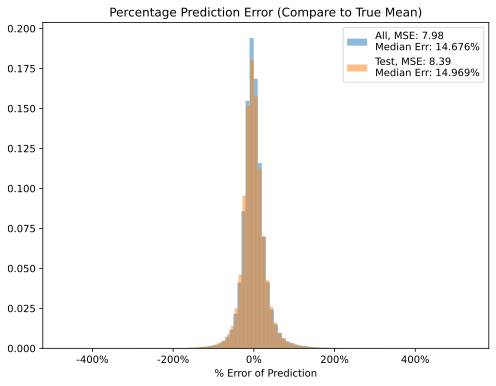

In [0]:
hist_plot('error', plot_type='test2all', suffix='test2all')

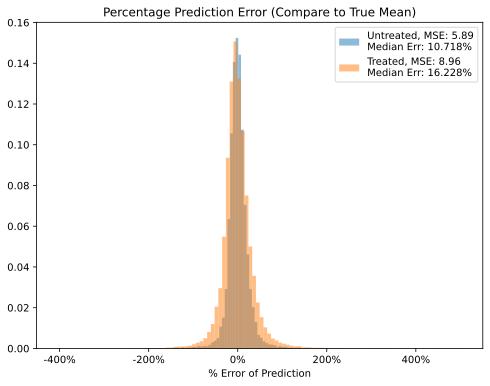

In [0]:
hist_plot('error', plot_type='treat2notreat', suffix='treat')

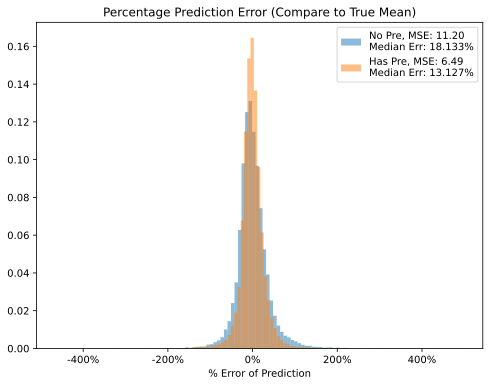

In [0]:
hist_plot('error', plot_type='pre2nopre', suffix='pre')

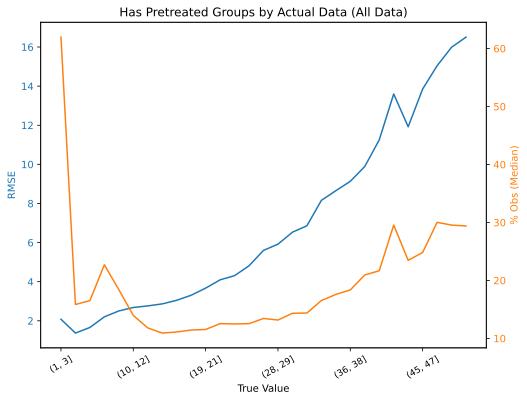

In [0]:
error_bin('All', treat=0, pretreat=1, suffix='pre', title_prefix='Has Pretreated')

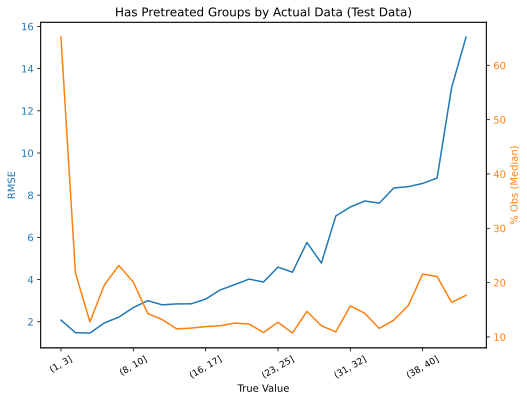

In [0]:
error_bin('Test', treat=0, pretreat=1, suffix='pre', title_prefix='Has Pretreated')

## Use Model to Select

In [0]:
dataframe_rank = dataframe_copy[['Household', Target[0], Target[0]+'_pred']].copy()
NumPercentile = 100

dataframe_pred = pd.read_csv('/tmp/IHWAP_CE.csv')
dataframe_pred.drop('jobnumber', axis=1, inplace=True)

for column in ['eng_savings_pct', 'eng_savings_mmbtu', 'realized_savings_pct', 'realized_savings_mmbtu']:
    dataframe_pred[column] = -dataframe_pred[column]

dataframe_rank = dataframe_rank.groupby(['Household']).mean()
dataframe_rank.reset_index(inplace=True)

dataframe_rank = dataframe_rank.merge(dataframe_pred[['Household', 'eng_savings_mmbtu']], left_on='Household', right_on='Household', validate='1:1')

In [0]:
# dataframe_rank[Target[0]] = -dataframe_rank[Target[0]]
# dataframe_rank[Target[0]+'_pred'] = -dataframe_rank[Target[0]+'_pred']

plot_results = pd.DataFrame()
for column in [col for col in dataframe_rank if col != 'Household']:

    dataframe_rank.sort_values(by=column, inplace=True)
    dataframe_rank.reset_index(drop=True, inplace=True)

    SaveQuan_Temp = dataframe_rank[column].quantile((1/NumPercentile)*np.arange(0,NumPercentile+1,1), interpolation='higher').to_frame(name='Percentile_Value')
    SaveQuan_Temp['Percentile_Index'] = [dataframe_rank[column].ge(i).idxmax() for i in SaveQuan_Temp.Percentile_Value]
    SaveQuan_Temp['Percentile'] = np.arange(0,NumPercentile+1,1)
    SaveQuan_Temp.reset_index(drop=True, inplace=True)
    SaveQuan_Temp = SaveQuan_Temp.reindex(index=SaveQuan_Temp.index[::-1])
    if column == Target[0]:
        plot_col_name = 'Above_True_Save_Sum'
    elif column == Target[0]+'_pred':
        plot_col_name = 'Above_Predict_Save_Sum'
    elif column == 'eng_savings_mmbtu':
        plot_col_name = 'Above_Eng_Save_Sum'

    plot_results[plot_col_name] = [np.sum(dataframe_rank[dataframe_rank.index >= i][Target[0]]) for i in SaveQuan_Temp.Percentile_Index]


plot_results['Diff_ML'] = plot_results['Above_True_Save_Sum'] - plot_results['Above_Predict_Save_Sum']
plot_results['Diff_Eng'] = plot_results['Above_True_Save_Sum'] - plot_results['Above_Eng_Save_Sum']
plot_results.reset_index(drop=True, inplace=True)
plot_results = plot_results.reindex(index=plot_results.index[::-1]).reset_index(drop=True)


In [0]:
random_choice = pd.DataFrame()
Quant_Index = -np.quantile(-dataframe_rank.index, (1/NumPercentile)*np.arange(0,NumPercentile+1,1), interpolation='nearest')

for i in range(0, 100):
    Rabndom_Data = dataframe_rank[Target[0]].sample(frac=1).to_frame().reset_index(drop=True)
    random_choice[str(i)] = [np.sum(Rabndom_Data[Rabndom_Data.index >= i][Target[0]]) for i in Quant_Index]

random_choice = random_choice.reindex(index=random_choice.index[::-1]).reset_index(drop=True)

plot_results['Rand_Avg'] = random_choice.mean(axis=1)
plot_results['Rand_UpStd'] = plot_results['Rand_Avg'] + random_choice.std(axis=1)
plot_results['Rand_DownStd'] = plot_results['Rand_Avg'] - random_choice.std(axis=1)

## Plot Selection

<Figure size 1600x1200 with 0 Axes>

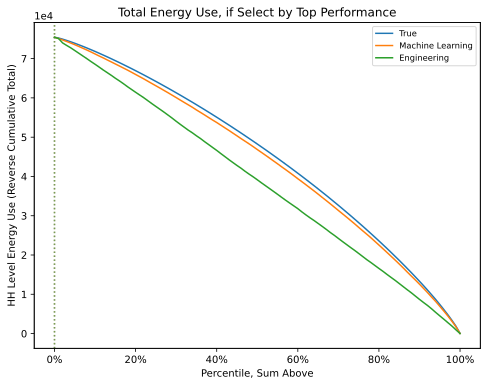

In [0]:
RankPlot(label='Energy Use', g='all')

<Figure size 1600x1200 with 0 Axes>

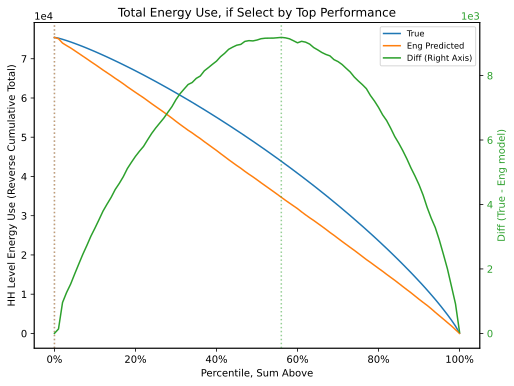

In [0]:
RankPlot(label='Energy Use', g='eng')

<Figure size 1600x1200 with 0 Axes>

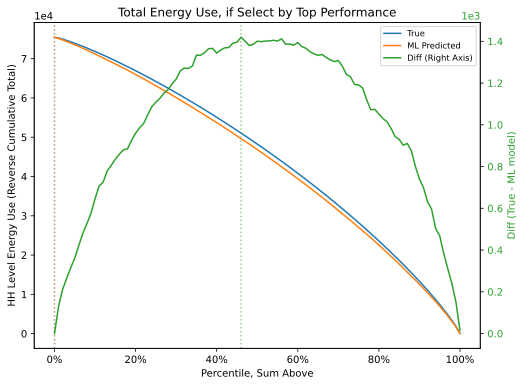

In [0]:
RankPlot(label='Energy Use', g='pred')

<Figure size 1600x1200 with 0 Axes>

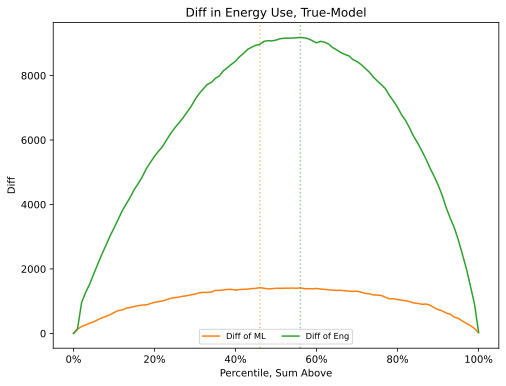

In [0]:
RankPlot(label='Energy Use', g='diff')

<Figure size 1600x1200 with 0 Axes>

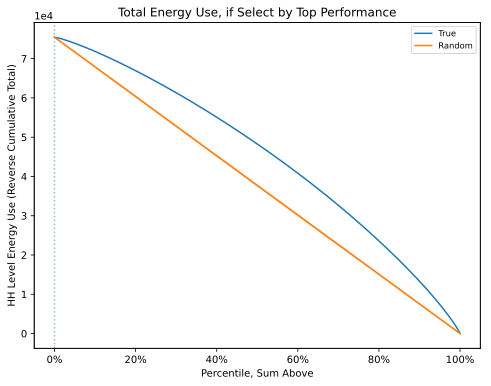

In [0]:
RankPlot(label='Energy Use', g='random')

## Save and Download

In [0]:
shutil.make_archive('/tmp/FitOutput_HH', 'zip', '/tmp/output')

'/tmp/FitOutput_HH.zip'

## Test